Unknown maqam type in file: Midi Oud Rast Rast Ascending Descending_frequencies.npz
Unknown maqam type in file: Midi Oud Rast Rast Ascending Descending_frequencies.npz


c:\Users\rbt04\AppData\Local\miniconda3\envs\ML_workspace\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/200], Loss: 4.8244
Epoch [2/200], Loss: 3.9419
Epoch [3/200], Loss: 3.6837
Epoch [4/200], Loss: 3.4922
Epoch [5/200], Loss: 3.3661
Epoch [6/200], Loss: 3.2775
Epoch [7/200], Loss: 3.2133
Epoch [8/200], Loss: 3.1671
Epoch [9/200], Loss: 3.1334
Epoch [10/200], Loss: 3.1067
Epoch [11/200], Loss: 3.0858
Epoch [12/200], Loss: 3.0670
Epoch [13/200], Loss: 3.0530
Epoch [14/200], Loss: 3.0399
Epoch [15/200], Loss: 3.0271
Epoch [16/200], Loss: 3.0173
Epoch [17/200], Loss: 3.0077
Epoch [18/200], Loss: 2.9974
Epoch [19/200], Loss: 2.9893
Epoch [20/200], Loss: 2.9803
Epoch [21/200], Loss: 2.9725
Epoch [22/200], Loss: 2.9651
Epoch [23/200], Loss: 2.9572
Epoch [24/200], Loss: 2.9493
Epoch [25/200], Loss: 2.9415
Epoch [26/200], Loss: 2.9343
Epoch [27/200], Loss: 2.9287
Epoch [28/200], Loss: 2.9240
Epoch [29/200], Loss: 2.9259
Epoch [30/200], Loss: 2.9142
Epoch [31/200], Loss: 2.9037
Epoch [32/200], Loss: 2.8941
Epoch [33/200], Loss: 2.8884
Epoch [34/200], Loss: 2.8845
Epoch [35/200], Loss: 2

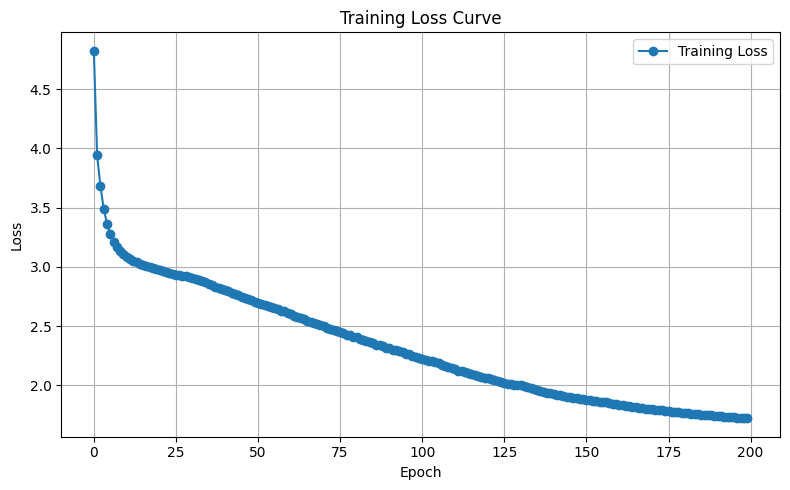

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
# --- Configuration ---
input_folder = r"C:\Users\rbt04\Desktop\Clustered_Frequencies"

# --- Maqam types ---
maqam_types = ['kurd', 'nahawand', 'segah', 'hijaz', 'rast', 'saba', 'hijazkar', 'bayat']

# --- Load frequencies, durations, and maqam types from files ---
frequencies, durations, maqam_type_labels = [], [], []

for filename in os.listdir(input_folder):
    if filename.endswith('.npz'):
        maqam_type = next((m for m in maqam_types if filename.lower().startswith(m)), None)
        if maqam_type:
            try:
                data = np.load(os.path.join(input_folder, filename))
                # Convert numpy arrays to Python native types
                freq_array = data['frequencies'].astype(float).tolist()  # Convert to Python floats
                dur_array = data['durations'].astype(int).tolist()       # Convert to Python ints
                frequencies.append(freq_array)
                durations.append(dur_array)
                maqam_type_labels.append(maqam_type)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"Unknown maqam type in file: {filename}")

# --- Flatten all data to extract unique tokens ---
all_frequencies = np.concatenate([np.array(lst) for lst in frequencies])
all_durations = np.concatenate([np.array(lst) for lst in durations])
unique_freqs = np.unique(all_frequencies)
unique_durations = np.unique(all_durations)


#Build the unique frequencies in the dataset that are between 50 and 400 Hz (OUD range), and then filter frequencies that are close
#  to each other as our training data set is relatively small so we can't afford having a large vocabulary given the OpenAi scaling law
filtered = unique_freqs[(unique_freqs >= 50) & (unique_freqs <= 400)]
sorted_filtered = np.sort(filtered)
differences = np.diff(sorted_filtered)
selected = [sorted_filtered[0]]
for i in range(1, len(sorted_filtered)):
    if sorted_filtered[i] - selected[-1] > 0.5:
        selected.append(sorted_filtered[i])

# the reference_frequencies represent the discretized frequencies that are used to tokenize the inputs
reference_frequencies = np.array(selected)

# the reference_durations represent the discretized durations that are used to tokenize the inputs
reference_durations = np.array([
    0, 5, 10, 15, 20, 25, 30, 35,
    40, 50,80,100,150,200,250,300
])
def project_to_nearest_reference(input_list, reference):
    """Projects each frequency in input_list to the closest value in reference."""
    input_list = np.array(input_list)
    indices = np.abs(input_list[:, None] - reference).argmin(axis=1)
    return reference[indices]
unique_freqs = reference_frequencies
unique_durations= reference_durations

for filename in os.listdir(input_folder):
    if filename.endswith('.npz'):
        maqam_type = next((m for m in maqam_types if filename.lower().startswith(m)), None)
        if maqam_type:
            try:
                data = np.load(os.path.join(input_folder, filename))
                # Convert numpy arrays to Python native types
                raw_freq_array = data['frequencies'].astype(float)
                projected_freq_array = project_to_nearest_reference(raw_freq_array, reference_frequencies)
                freq_array = projected_freq_array.tolist()



                # freq_array = data['frequencies'].astype(float).tolist()  # Convert to Python floats
                # dur_array = data['durations'].astype(int).tolist()       # Convert to Python ints
                raw_dur_array = data['durations'].astype(int)      # Convert to Python ints
                projected_dur_array = project_to_nearest_reference(raw_dur_array, reference_durations)
                dur_array = projected_dur_array.tolist()

                frequencies.append(freq_array)
                durations.append(dur_array)
                maqam_type_labels.append(maqam_type)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"Unknown maqam type in file: {filename}")



# --- Create tokenization dictionaries ---
def create_combined_tokenization_dictionaries(maqam_types, unique_freqs, unique_durations):
    #Adding the Padding and the UNK tokens
    token_to_value = {0: "PAD"}
    value_to_token = {"PAD": 0}
    token_to_value[1] = "UNK"  
    value_to_token["UNK"] = 1
    current_index = 2


    # Maqam types
    for m in maqam_types:
        token_to_value[current_index] = m
        value_to_token[m] = current_index
        current_index += 1
    # Frequencies (use formatted token names)
    for f in unique_freqs:
        freq_token = f"freq_{round(f, 2)}"  # round for consistent string formatting
        token_to_value[current_index] = freq_token
        value_to_token[freq_token] = current_index
        current_index += 1

    # Durations (use formatted token names)
    for d in unique_durations:
        dur_token = f"duration_{int(d)}"
        token_to_value[current_index] = dur_token
        value_to_token[dur_token] = current_index
        current_index += 1


    # Adding EOS token to the end of the sequence
    token_to_value[current_index] = "EOS"
    value_to_token["EOS"] = current_index
    return token_to_value, value_to_token

token_to_value, value_to_token = create_combined_tokenization_dictionaries(maqam_types, unique_freqs, unique_durations)
eos_token = value_to_token["EOS"]

# --- Tokenization utilities ---
def tokenize_combined(sequence, value_to_token):
    tokenized_sequence = []
    for element in sequence:
        # to remove the numpy type
        if isinstance(element, np.generic):
            element = element.item()
        key = str(element)
        if key in value_to_token:
            tokenized_sequence.append(value_to_token[key])
        else:
            tokenized_sequence.append(value_to_token[1])
    tokenized_sequence.append(value_to_token["EOS"])
    return tokenized_sequence

def detokenize_combined(tokenized_sequence, token_to_value):
    return [token_to_value[int(token)] for token in tokenized_sequence]


def build_token_sequences(type_tokens, freq_tokens, dur_tokens, target_length=None, pad_token=0, eos_token=None):
    assert len(type_tokens) == len(freq_tokens) == len(dur_tokens), "Input lists must match in length"
    token_sequences = []
    for t, freqs, durs in zip(type_tokens, freq_tokens, dur_tokens):
        assert len(freqs) == len(durs), "Frequencies and durations must match in length"
        pair_token_count = 2
        overhead = 1  # type token at the beginning
        max_pairs = ((target_length - overhead - 1) // pair_token_count) if target_length else None  # -1 for possible EOS

        i = 0
        while i < len(freqs):
            seq = [t]
            end = i + max_pairs if max_pairs else len(freqs)
            freq_dur_pairs = list(zip(freqs[i:end], durs[i:end]))
            for f, d in freq_dur_pairs:

                f_token = value_to_token.get(f"freq_{round(float(f), 2)}", value_to_token["UNK"])
                d_token = value_to_token.get(f"duration_{int(d)}", value_to_token["UNK"])

                seq.extend([f_token, d_token])
            i = end

            # Add EOS only if this is the last chunk and there's room
            if eos_token is not None and i >= len(freqs):
                if target_length is None or len(seq) + 1 <= target_length:
                    seq.append(eos_token)

            # Pad to target_length
            if target_length and len(seq) < target_length:
                seq += [pad_token] * (target_length - len(seq))

            token_sequences.append(seq)
    return token_sequences

# --- Prepare maqam type tokens ---
type_tokens = [value_to_token[m] for m in maqam_type_labels]

# --- Build tokenized sequences ---
sequences = build_token_sequences(type_tokens, frequencies, durations, target_length=1024, pad_token=0, eos_token=eos_token)
train_data, Combined_data = train_test_split(sequences, test_size=0.25, random_state=42)
test_data, val_data = train_test_split(sequences, test_size=0.25, random_state=69)

# --- Define Dataset Class ---
class MyDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        input_sequence = sequence[:-1]  # All except the last element
        target_sequence = sequence[1:]  # All except the first element
        
        input_tensor = torch.tensor(input_sequence, dtype=torch.long)
        target_tensor = torch.tensor(target_sequence, dtype=torch.long)
        
        return input_tensor, target_tensor

# --- Model Architecture with Dropout ---
class AutoregressiveTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers, hidden_dim, max_len=512, dropout=0.2):
        super(AutoregressiveTransformer, self).__init__()
        self.type_embedding=nn.Embedding(6,embed_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Embedding(max_len, embed_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = x.long()  # Ensure input is of type LongTensor
        seq_len, batch_size = x.size()

        # Compute type embedding per token based on its value
        token_types = torch.zeros_like(x)           #Default BOS
        token_types[(x >= 1) & (x < 2)] = 1        # PAD
        token_types[(x >= 2) & (x <= 9)] = 2        # Maqam types
        token_types[(x >= 10) & (x <= 435)] = 3     # Frequencies
        token_types[(x >= 436) & (x <= 451)] = 4   # Durations
        token_types[x ==452] = 5                   # EOS or others

        type_embeddings = self.type_embedding(token_types)

        # Positional encoding: shape (seq_len, 1) → broadcasted across batch
        positions = torch.arange(seq_len, device=x.device).unsqueeze(1).expand(seq_len, x.size(1))
        pos_encoding = self.positional_encoding(positions)

        embeddings = self.embedding(x) + pos_encoding + type_embeddings
        embeddings = self.dropout(embeddings)

        transformer_output = self.transformer(embeddings)
        output = self.fc_out(transformer_output)

        return output


# --- Training Setup ---
# Define hyperparameters
vocab_size = 453
embed_size = 256
num_heads = 8
num_layers = 6

hidden_dim = 256
seq_length = 1024
batch_size = 128
num_epochs = 200
learning_rate = 0.0001

# Create the Dataset and DataLoader
context_size = 1024
train_dataset = MyDataset(train_data, context_size)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = AutoregressiveTransformer(vocab_size, embed_size, num_heads, num_layers, hidden_dim)
model = model.cuda() if torch.cuda.is_available() else model

criterion = nn.CrossEntropyLoss(ignore_index=0)  # Padding index
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for input_seq, target_seq in dataloader:
        input_seq, target_seq = input_seq.cuda(), target_seq.cuda()

        input_seq = input_seq.long()
        target_seq = target_seq.long()

        output = model(input_seq)
        loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Step the learning rate scheduler
    scheduler.step(epoch_loss)
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Unknown maqam type in file: Midi Oud Rast Rast Ascending Descending_frequencies.npz


c:\Users\rbt04\AppData\Local\miniconda3\envs\ML_workspace\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 001: Train=6.3394, Val=6.1031, Test=6.1648
Epoch 002: Train=6.1478, Val=5.9199, Test=5.9690
Epoch 003: Train=5.9728, Val=5.7599, Test=5.7944
Epoch 004: Train=5.7990, Val=5.6250, Test=5.6466
Epoch 005: Train=5.6613, Val=5.5109, Test=5.5230
Epoch 006: Train=5.5449, Val=5.4116, Test=5.4180
Epoch 007: Train=5.4413, Val=5.3233, Test=5.3268
Epoch 008: Train=5.3539, Val=5.2435, Test=5.2457
Epoch 009: Train=5.2688, Val=5.1706, Test=5.1726
Epoch 010: Train=5.1960, Val=5.1038, Test=5.1061
Epoch 011: Train=5.1249, Val=5.0422, Test=5.0448
Epoch 012: Train=5.0621, Val=4.9851, Test=4.9880
Epoch 013: Train=5.0055, Val=4.9316, Test=4.9351
Epoch 014: Train=4.9532, Val=4.8815, Test=4.8857
Epoch 015: Train=4.9017, Val=4.8348, Test=4.8401
Epoch 016: Train=4.8556, Val=4.7916, Test=4.7982
Epoch 017: Train=4.8116, Val=4.7519, Test=4.7600
Epoch 018: Train=4.7730, Val=4.7156, Test=4.7254
Epoch 019: Train=4.7340, Val=4.6827, Test=4.6941
Epoch 020: Train=4.7013, Val=4.6527, Test=4.6657
Epoch 021: Train=4.6

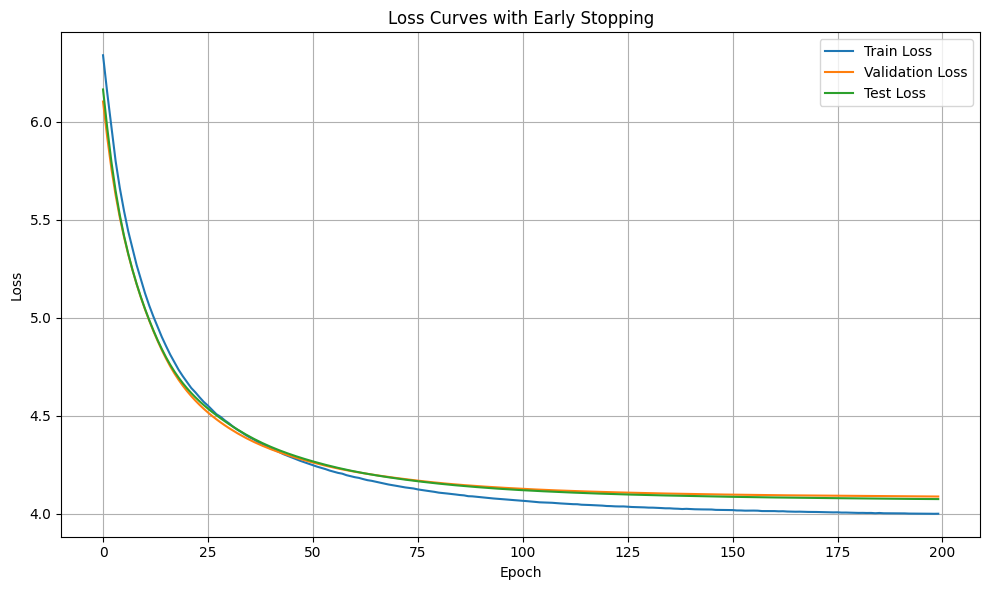

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# --- Configuration ---
input_folder = r"C:\Users\rbt04\Desktop\Clustered_Frequencies"

# --- Maqam types ---
maqam_types = ['kurd', 'nahawand', 'segah', 'hijaz', 'rast', 'saba', 'hijazkar', 'bayat']

# --- Load frequencies, durations, and maqam types from files ---
frequencies, durations, maqam_type_labels = [], [], []

for filename in os.listdir(input_folder):
    if filename.endswith('.npz'):
        maqam_type = next((m for m in maqam_types if filename.lower().startswith(m)), None)
        if maqam_type:
            try:
                data = np.load(os.path.join(input_folder, filename))
                freq_array = data['frequencies'].astype(float).tolist()
                dur_array = data['durations'].astype(int).tolist()
                frequencies.append(freq_array)
                durations.append(dur_array)
                maqam_type_labels.append(maqam_type)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"Unknown maqam type in file: {filename}")

# --- Frequency preprocessing ---
all_frequencies = np.concatenate([np.array(lst) for lst in frequencies])
filtered = all_frequencies[(all_frequencies >= 50) & (all_frequencies <= 400)]
sorted_filtered = np.sort(filtered)
selected = [sorted_filtered[0]]
for i in range(1, len(sorted_filtered)):
    if sorted_filtered[i] - selected[-1] > 0.5:
        selected.append(sorted_filtered[i])
reference_frequencies = np.array(selected)
reference_durations = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 80, 100, 150, 200, 250, 300])

def project_to_nearest_reference(input_list, reference):
    input_list = np.array(input_list)
    indices = np.abs(input_list[:, None] - reference).argmin(axis=1)
    return reference[indices]

# --- Reload and project all data ---
frequencies, durations, maqam_type_labels = [], [], []
for filename in os.listdir(input_folder):
    if filename.endswith('.npz'):
        maqam_type = next((m for m in maqam_types if filename.lower().startswith(m)), None)
        if maqam_type:
            try:
                data = np.load(os.path.join(input_folder, filename))
                projected_freq_array = project_to_nearest_reference(data['frequencies'].astype(float), reference_frequencies)
                projected_dur_array = project_to_nearest_reference(data['durations'].astype(int), reference_durations)
                frequencies.append(projected_freq_array.tolist())
                durations.append(projected_dur_array.tolist())
                maqam_type_labels.append(maqam_type)
            except Exception as e:
                print(f"Error loading {filename}: {e}")

# --- Token dictionaries ---
def create_combined_tokenization_dictionaries(maqam_types, unique_freqs, unique_durations):
    token_to_value = {0: "PAD", 1: "UNK"}
    value_to_token = {"PAD": 0, "UNK": 1}
    current_index = 2
    for m in maqam_types:
        token_to_value[current_index] = m
        value_to_token[m] = current_index
        current_index += 1
    for f in unique_freqs:
        freq_token = f"freq_{round(f, 2)}"
        token_to_value[current_index] = freq_token
        value_to_token[freq_token] = current_index
        current_index += 1
    for d in unique_durations:
        dur_token = f"duration_{int(d)}"
        token_to_value[current_index] = dur_token
        value_to_token[dur_token] = current_index
        current_index += 1
    token_to_value[current_index] = "EOS"
    value_to_token["EOS"] = current_index
    return token_to_value, value_to_token

token_to_value, value_to_token = create_combined_tokenization_dictionaries(maqam_types, reference_frequencies, reference_durations)
eos_token = value_to_token["EOS"]

def build_token_sequences(type_tokens, freq_tokens, dur_tokens, target_length=None, pad_token=0, eos_token=None):
    assert len(type_tokens) == len(freq_tokens) == len(dur_tokens)
    token_sequences = []
    for t, freqs, durs in zip(type_tokens, freq_tokens, dur_tokens):
        assert len(freqs) == len(durs)
        max_pairs = ((target_length - 2) // 2) if target_length else None
        i = 0
        while i < len(freqs):
            seq = [t]
            end = i + max_pairs if max_pairs else len(freqs)
            for f, d in zip(freqs[i:end], durs[i:end]):
                f_token = value_to_token.get(f"freq_{round(float(f), 2)}", 1)
                d_token = value_to_token.get(f"duration_{int(d)}", 1)
                seq.extend([f_token, d_token])
            i = end
            if eos_token is not None and i >= len(freqs):
                if target_length is None or len(seq) + 1 <= target_length:
                    seq.append(eos_token)
            if target_length and len(seq) < target_length:
                seq += [pad_token] * (target_length - len(seq))
            token_sequences.append(seq)
    return token_sequences

type_tokens = [value_to_token[m] for m in maqam_type_labels]
sequences = build_token_sequences(type_tokens, frequencies, durations, target_length=1024, pad_token=0, eos_token=eos_token)

# --- Data split ---
train_data, temp_data = train_test_split(sequences, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# --- Dataset & Dataloader ---
class MyDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        input_sequence = sequence[:-1]
        target_sequence = sequence[1:]
        return torch.tensor(input_sequence), torch.tensor(target_sequence)

train_dataset = MyDataset(train_data, context_size)
val_dataset = MyDataset(val_data, context_size)
test_dataset = MyDataset(test_data, context_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- Model ---
class AutoregressiveTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers, hidden_dim, max_len=512, dropout=0.2):
        super().__init__()
        self.type_embedding = nn.Embedding(6, embed_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Embedding(max_len, embed_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_size, num_heads, hidden_dim, dropout),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.long()
        seq_len, batch_size = x.size()
        token_types = torch.zeros_like(x)
        token_types[(x >= 1) & (x < 2)] = 1
        token_types[(x >= 2) & (x <= 9)] = 2
        token_types[(x >= 10) & (x <= 435)] = 3
        token_types[(x >= 436) & (x <= 451)] = 4
        token_types[x == 452] = 5

        type_embeddings = self.type_embedding(token_types)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(1).expand(seq_len, batch_size)
        pos_encoding = self.positional_encoding(positions)
        embeddings = self.embedding(x) + pos_encoding + type_embeddings
        embeddings = self.dropout(embeddings)
        transformer_output = self.transformer(embeddings)
        return self.fc_out(transformer_output)

# --- Training ---

# --- Training Setup ---
# Define hyperparameters
vocab_size = 453
embed_size = 256
num_heads = 8
num_layers = 6

context_size = 1024
batch_size = 512
hidden_dim = 256
seq_length = 1024
batch_size = 128
num_epochs = 200
learning_rate = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(token_to_value)
model = AutoregressiveTransformer(vocab_size, 256, 8, 6, 256, max_len=1024).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

train_losses, val_losses, test_losses = [], [], []
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(200):
    model.train()
    running_loss = 0.0
    for input_seq, target_seq in train_loader:
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)
        optimizer.zero_grad()
        output = model(input_seq)
        loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input_seq, target_seq in val_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            output = model(input_seq)
            loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # --- Test ---
    test_loss = 0.0
    with torch.no_grad():
        for input_seq, target_seq in test_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            output = model(input_seq)
            loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1:03d}: Train={train_loss:.4f}, Val={val_loss:.4f}, Test={test_loss:.4f}")
    scheduler.step(val_loss)

    # --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves with Early Stopping")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
def generate_sequence(model, start_sequence, max_length=context_size, temperature=1.0):
    model.eval()  # Set model to evaluation mode
    sequence = start_sequence
    sequence_tensor = torch.tensor(sequence).unsqueeze(1).cuda()  # Shape: (seq_length, 1)
    
    with torch.no_grad():
        for _ in range(max_length - len(sequence)):
            output = model(sequence_tensor)
            logits = output[-1, :, :] / temperature  # Apply temperature
            
            probabilities = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probabilities, 1).item()
            
            sequence.append(next_token)
            sequence_tensor = torch.tensor(sequence).unsqueeze(1).cuda()

    return sequence

# Example usage of sequence generation
generated_sequence = generate_sequence(model, start_sequence=[1, 74, 583], temperature=0.8)

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling cublasLtMatmul with transpose_mat1 1 transpose_mat2 0 m 768 n 3 k 256 mat1_ld 256 mat2_ld 256 result_ld 768 abcType 0 computeType 68 scaleType 0

In [6]:
def generate_sequence(model, start_sequence, max_length=context_size, temperature=1.0, eos_token=eos_token):
    device = next(model.parameters()).device  # Get device dynamically
    model.eval()
    sequence = start_sequence.copy()
    with torch.no_grad():
        for _ in range(max_length - len(sequence)):
            input_tensor = torch.tensor([sequence]).to(device)  # (1, seq_len)
            input_tensor = input_tensor.transpose(0, 1)  # (seq_len, 1)

            output = model(input_tensor)  # (seq_len, 1, vocab_size)
            logits = output[-1, :, :] / temperature  # (1, vocab_size)

            probabilities = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probabilities, 1).item()

            sequence.append(next_token)

            if next_token == eos_token:
                break  # Stop early if EOS is generated

            # Optional: Trim sequence to keep memory manageable
            if len(sequence) > context_size:
                sequence = sequence[-context_size:]

    return sequence
# Try with a valid known starting token
generated = generate_sequence(model, start_sequence=[9,18,436,182,428,70])
print(detokenize_combined(generated, token_to_value))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import numpy as np
import sounddevice as sd
def extract_freqs_durs(token_list):
    frequencies = []
    durations = []

    i = 0
    while i < len(token_list):
        token = token_list[i]

        # Look ahead for freq/dur pairs
        if token.startswith("freq_"):
            # Try to find the next dur_
            if i + 1 < len(token_list) and token_list[i + 1].startswith("dur_"):
                freq_value = float(token.replace("freq_", ""))
                dur_value = int(token_list[i + 1].replace("dur_", ""))
                frequencies.append(freq_value)
                durations.append(dur_value)
                i += 2  # Skip both tokens
            else:
                # No corresponding duration found
                i += 1
        else:
            i += 1

    return frequencies, durations

generated_tokens = detokenize_combined(generated_sequence)

frequencies, duration = extract_freqs_durs(generated_tokens)
sample_rate=22000

# Sine wave generator

def sine_wave(freq, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    return np.sin(2 * np.pi * freq * t)

# Combine all sine waves
waveform = np.concatenate([
    sine_wave(freq, duration, sample_rate)
    for freq in frequencies
])

# Normalize waveform
waveform /= np.max(np.abs(waveform))

# Play it
sd.play(waveform, samplerate=sample_rate)
sd.wait()
